# importing required libraries

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from tqdm.notebook import tqdm

# Defining function that adds noise

In [2]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

# Transformations

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0,std=1)
])

# downloading and loading the data

In [4]:
trainset = MNIST('./data',train=True,transform=img_transform, download=True)
testset = MNIST('./data',train=False,transform=img_transform, download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader=DataLoader(testset, batch_size=128, shuffle=False)

# Defining model architecture

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
        self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
    
        return x


# Fuction that trains model

In [6]:
def training(model,optimizer,criterion,epochs):
    hist={"loss":[],"MSE":[]}
    for epoch in tqdm(range(1,epochs+1),desc="Training",total=epochs):
        losses=[]
        mselosses=[]
        for data in trainloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            noisy_img = add_noise(img)
            noisy_img = Variable(noisy_img)
            img = Variable(img)
        # ===================forward=====================
            output = model(noisy_img)
            loss = criterion(output, img)
            losses.append(loss.item())
            MSE_loss = nn.MSELoss()(output, img)
            mselosses.append(MSE_loss.item())
        # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        hist["loss"].append(np.array(losses).mean())
        hist["MSE"].append(np.array(mselosses).mean())
    return hist

# Hyperparameter initialisation and training

In [7]:
model=autoencoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001)
epochs=50
hist=training(model,optimizer,criterion,epochs)

# Visualising loss 

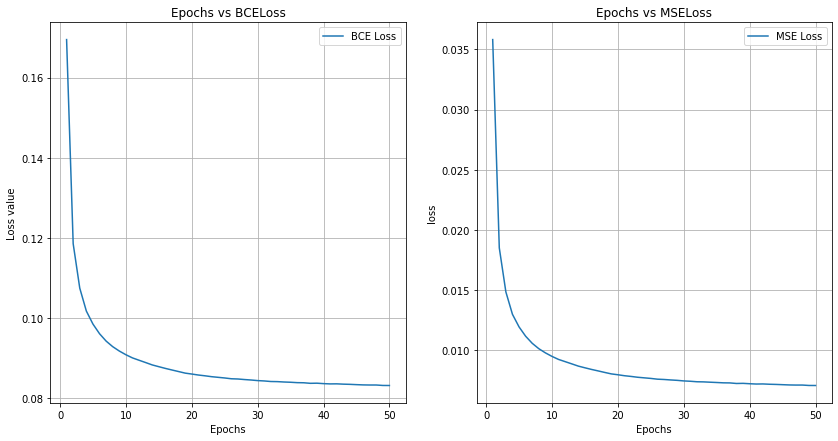

In [8]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax[0].plot(range(1,epochs+1),hist["loss"],label="BCE Loss")
ax[0].grid()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss value")
ax[0].set_title("Epochs vs BCELoss")
ax[0].legend()
ax[1].plot(range(1,epochs+1),hist["MSE"],label="MSE Loss")    
ax[1].grid()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("Epochs vs MSELoss")
ax[1].legend()

In [9]:
torch.save(model.state_dict(),"MNISTdenoisingweights.pth")

In [16]:
def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

# performance on test data

In [17]:
for i,data in enumerate(testloader):
    if(i==1):
        break;
    img,_=data
    img=img.view(img.size(0),-1)
    noisy_img=add_noise(img)
    output=model(noisy_img)
    img=Variable(img)
    noisy_image=Variable(noisy_img)
    original= to_img(img)
    clear= to_img(output)
    noised= to_img(noisy_img)
    save_image(original, './outputs/original.png')
    save_image(noised, './outputs/noised.png')
    save_image(clear, './outputs/clear.png')
